In [1]:
import casadi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import scienceplots
plt.style.use(['science','ieee','high-vis','grid']) # ここでスタイルを設定する

### パラメータ設定

In [2]:
ρ = 1025.0  # 海水密度

# suzaku
nabla = 0.2358  # 排水量[m3] Lpp*B:d*Cb
L_pp = 3.50  # 船長Lpp[m]
B = 0.57  # 船幅[m]
d = 0.16  # 喫水[m]
x_G = 0.0112  # 重心位置[]
C_b = 0.7390 # 方形係数
D_p = 0.03373 * L_pp #0.120  # プロペラ直径[m]
m = 1025 * nabla  # 質量(無次元化)[kg]
A_R = 0.0189  # 船の断面に対する舵面積比[-]
# H_R = 0.1495  # 舵高さ[m]
η = 0.8023  # プロペラ直径に対する舵高さ(Dp/H)
m_x_dash = 0.0475 # 付加質量x(無次元) kg/m3 * m2 * m /kg
m_y_dash = 0.6739 # 付加質量y(無次元)
J_z_dash = 0.0306 # 付加質量Izz(無次元)
f_α = 2.634 # 直圧力勾配係数
ϵ = 1.345  # プロペラ・舵位置伴流係数比
t_R = 0.084  # 操縦抵抗減少率 
a_H = 0.054  # 舵力増加係数
x_H = -0.388 * L_pp  # 舵力増分作用位置
γ_R_minus = 0.225 # 整流係数
γ_R_plus = 0.574  # 整流係数
l_r_dash = -0.641  # 船長に対する舵位置
κ = 0.482  # 修正係数
t_P = 0.035  # 推力減少率 #モデルの違い
w_P0 = 0.397  # 有効伴流率 #モデルの違い
# t_P = 0.180  # 推力減少率 #モデルの違い
# w_P0 = 0.40  # 有効伴流率 #モデルの違い
x_P = -0.490  # 船長に対するプロペラ位置 #モデルの違い
x_R = -0.500 * L_pp
I_zG=ρ * nabla * ((0.25 * L_pp) ** 2)
m_x=(0.5 * ρ * (L_pp ** 2) * d) * m_x_dash  # 付加質量x(無次元)
m_y=(0.5 * ρ * (L_pp ** 2) * d) * m_y_dash  # 付加質量y(無次元)
J_z=(0.5 * ρ * (L_pp ** 4) * d) * J_z_dash  # 付加質量Izz(無次元)

In [3]:
k_0 = 0.3516
k_1 = -0.3624
k_2 = -0.1100
R_0_dash = 0.020
X_vv_dash = -0.07993
X_vr_dash = 0.10163
X_rr_dash = -0.01487
X_vvvv_dash = 0.57037
Y_v_dash = -0.37112
Y_r_dash = 0.07203
# Y_v_dash = -0.3384 #-0.37112
# Y_r_dash = 0.1976 #0.07203
Y_vvv_dash = -1.05345
Y_vvr_dash = 0.20726
Y_vrr_dash = -0.25560
Y_rrr_dash = 0.02196
N_v_dash = -0.10969
N_r_dash = -0.04994
# N_v_dash = -0.1377 #-0.10969
# N_r_dash = -0.0992#-0.04994
N_vvv_dash = -0.05329
N_vvr_dash = -0.28770
N_vrr_dash = -0.02059
N_rrr_dash = -0.01959

In [4]:
def X_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    v_dash=v/U
    return 0.5*ρ*L_pp*d*U**2*X_H_dash(v_dash,r_dash)

def Y_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    v_dash=v/U
    return 0.5*ρ*L_pp*d*U**2*Y_H_dash(v_dash,r_dash)

def N_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    v_dash=v/U
    return 0.5*ρ*L_pp**2*d*U**2*N_H_dash(v_dash,r_dash)

def X_H_dash(β,r_dash):
    return -R_0_dash+X_vv_dash*β**2+X_vr_dash*β*r_dash+X_rr_dash*r_dash**2+X_vvvv_dash*β**4

def Y_H_dash(β,r_dash):
    return Y_v_dash*β+Y_r_dash*r_dash+Y_vvr_dash*β**2*r_dash+Y_vrr_dash*β*r_dash**2+Y_vvv_dash*β**3+Y_rrr_dash*r_dash**3

def N_H_dash(β,r_dash):
    return N_v_dash*β+N_r_dash*r_dash+N_vvr_dash*β**2*r_dash+N_vrr_dash*β*r_dash**2+N_vvv_dash*β**3+N_rrr_dash*r_dash**3

def X_R(u,v,r,δ,n_p):
    return -(1-t_R)*F_N(u,v,r,δ,n_p)*np.sin(δ)

def Y_R(u,v,r,δ,n_p):
    return -(1+a_H)*F_N(u,v,r,δ,n_p)*np.cos(δ)

def N_R(u,v,r,δ,n_p):
    return -(x_R+a_H*x_H)*F_N(u,v,r,δ,n_p)*np.cos(δ)

def F_N(u,v,r,δ,n_p):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/U)
    r_dash=r*L_pp/U
    w_P = w_P0 * np.exp(-4.0 * (β - x_P * r_dash) ** 2)
    u_p=(1-w_P)*u
    u_R=ϵ*u_p*np.sqrt(η*(1+κ*(np.sqrt(1+(8*K_T(u,v,r,n_p))/(np.pi*J(u,v,r,n_p)**2))-1))**2+(1-η))
    v_R=U*γ_R_plus*(β-l_r_dash*r_dash)
    α_R=δ-np.arctan(v_R/u_R)
    U_R=np.sqrt(u_R**2+v_R**2)
    return 0.5*ρ*A_R*U_R**2*f_α*np.sin(α_R)

def X_P(u,v,r,δ,n_p):
    return (1-t_P)*T_P(u,v,r,n_p)

def K_T(u,v,r,n_p):
    return k_0+k_1*J(u,v,r,n_p)+k_2*J(u,v,r,n_p)**2

def J(u,v,r,n_p):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/U)
    r_dash=r*L_pp/U
    w_P = w_P0 * np.exp(-4.0 * (β - x_P * r_dash) ** 2)
    return u*(1-w_P)/(n_p*D_p)

def T_P(u,v,r,n_p):
    return K_T(u,v,r,n_p)*ρ*n_p**2*D_p**4

In [5]:
# 目標軌道の設定
# obs = pd.read_csv('observation/suzaku_obs.csv')
# obs = pd.read_csv('observation/suzaku_0ef_20deg 2.csv')
obs = pd.read_csv('observation/suzaku_z_obs.csv')
obs

,Unnamed: 0,time_list,u,v,r,x,y,psi,δ,npm,...,X_R_ref,X_P_ref,Y_H_ref,Y_R_ref,N_H_ref,N_R_ref,x_bow,y_bow,x_stern,y_stern
0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.0,...,-0.000000,5.471704,0.000000,-0.000000,-0.000000,0.000000,1.750000,0.000000,-1.750000,0.000000
1,1,1.0,0.018230,-0.001252,0.003530,0.009249,-0.000457,0.003530,0.174533,9.0,...,-0.231884,5.394752,0.008617,-1.315082,-0.010918,2.617719,1.759238,0.005719,-1.740741,-0.006634
2,2,2.0,0.035215,-0.003434,0.009561,0.036043,-0.002667,0.013091,0.174533,9.0,...,-0.215342,5.304133,0.053079,-1.221265,-0.067772,2.430974,1.785893,0.020241,-1.713807,-0.025574
3,3,3.0,0.051684,-0.005626,0.015348,0.079589,-0.006593,0.028438,0.174533,9.0,...,-0.199109,5.217641,0.133580,-1.129204,-0.169359,2.247722,1.828881,0.043167,-1.669704,-0.056353
4,4,4.0,0.067640,-0.007782,0.020638,0.139469,-0.011546,0.049076,0.174533,9.0,...,-0.184054,5.134812,0.242682,-1.043819,-0.303153,2.077761,1.887362,0.074303,-1.608424,-0.097395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,196,196.0,0.618031,-0.046187,0.033855,96.214031,-6.610624,0.049530,0.174533,9.0,...,-0.213423,3.111549,4.733215,-1.210380,-0.670506,2.409306,97.961884,-6.523983,94.466177,-6.697266
197,197,197.0,0.614883,-0.048256,0.034589,96.832059,-6.627497,0.084118,0.174533,9.0,...,-0.206650,3.112678,4.898407,-1.171972,-0.621477,2.332854,98.575871,-6.480464,95.088247,-6.774530
198,198,198.0,0.611445,-0.050207,0.035270,97.447193,-6.625274,0.119389,0.174533,9.0,...,-0.200184,3.115217,5.050007,-1.135302,-0.575434,2.259861,99.184736,-6.416839,95.709651,-6.833708
199,199,199.0,0.607742,-0.052042,0.035903,98.058554,-6.603668,0.155292,0.174533,9.0,...,-0.194020,3.119094,5.188298,-1.100342,-0.532417,2.190272,99.787495,-6.332999,96.329612,-6.874337


(-3.0, 3.0)

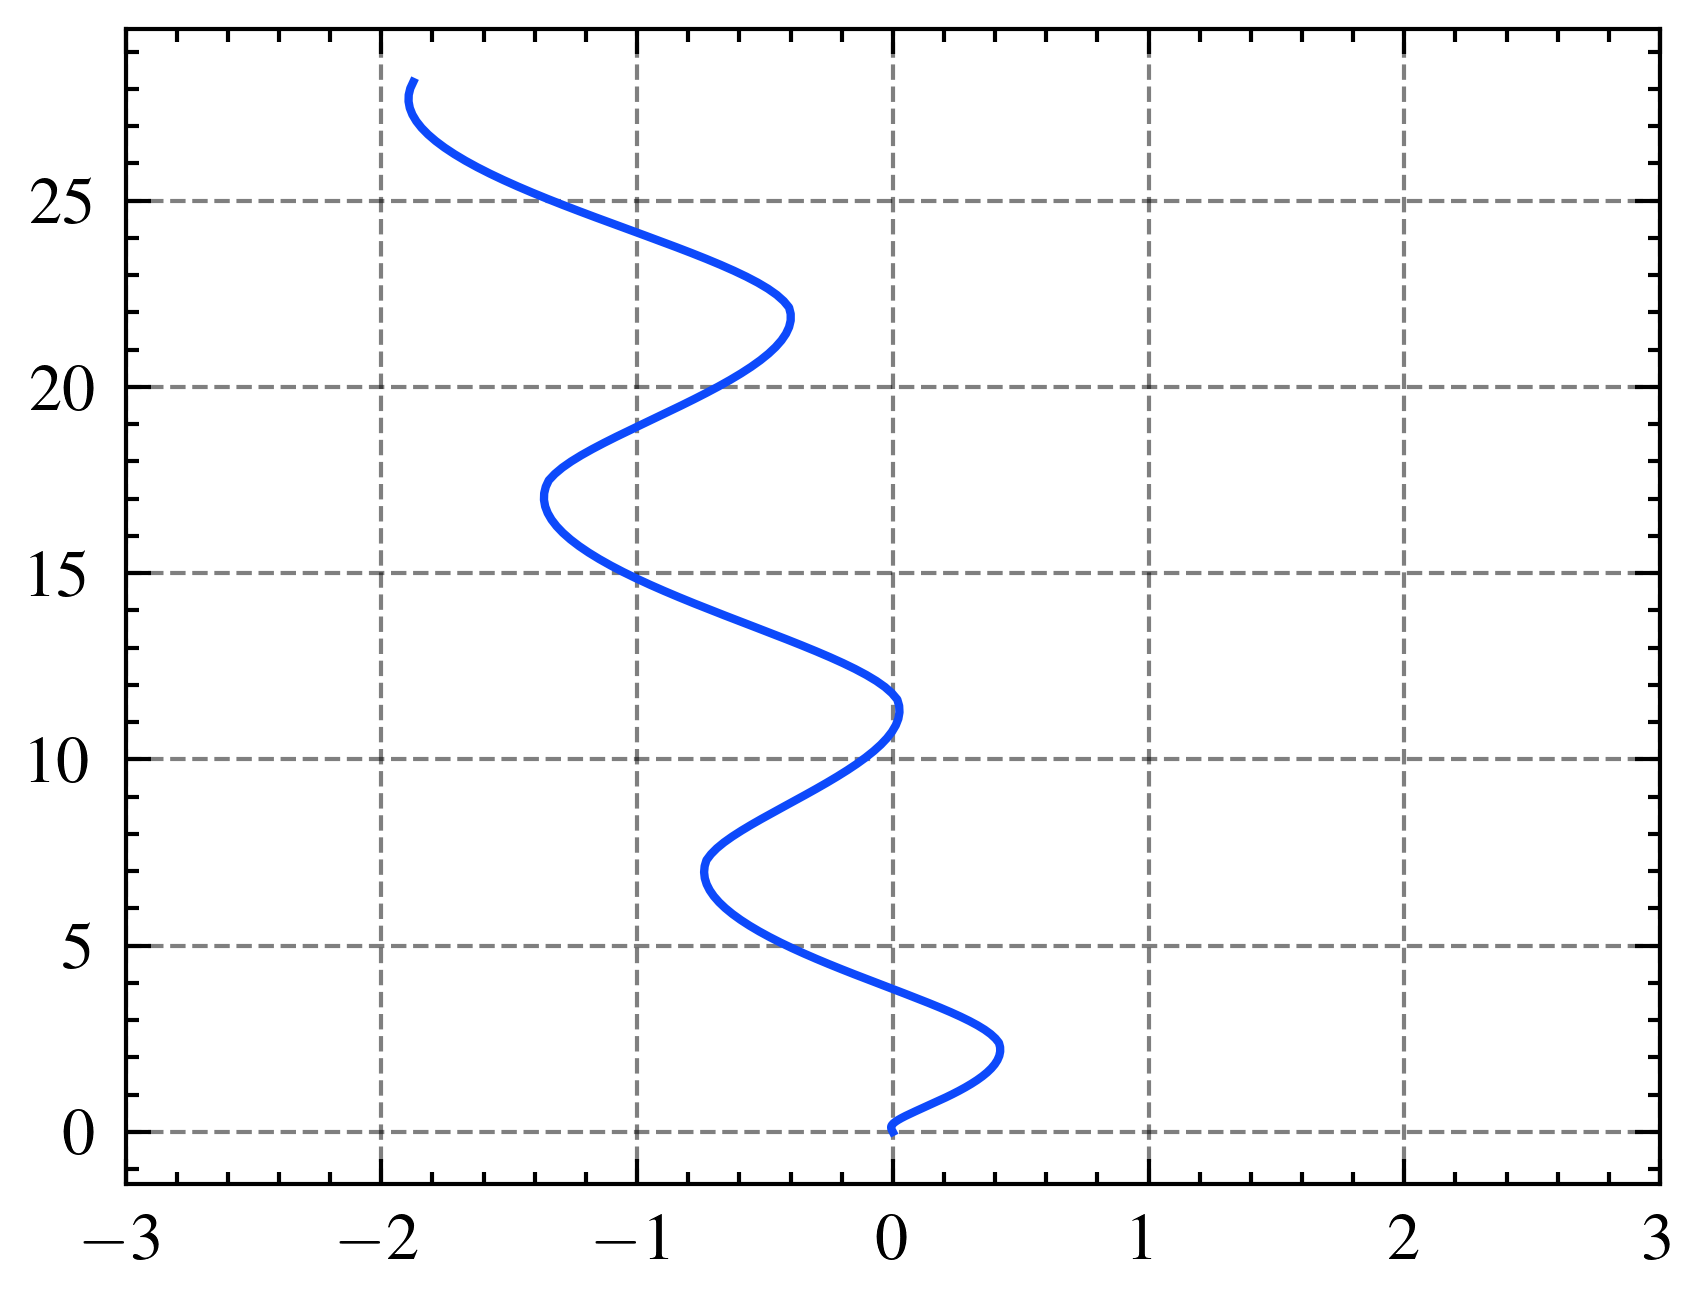

In [42]:
plt.plot(obs['y']/L_pp, obs['x']/L_pp)
plt.xlim(-3,3)

In [7]:
# 評価関数の重み
Q = casadi.diag([10,10,10,10]) # 状態変数の重み
Q_f = casadi.diag([10,10,10,10])
R = casadi.diag([1e-5,1e-5,1e-6]) # 制御入力の重み

# ホライゾン
K = 50
T = 130
dt = 1

# 制約条件
x_lb = [-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
x_ub = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
u_lb = [-10, -10, -10]
u_ub = [10, 10, 10]

nx = 8 # 状態変数の次元
nu = 3 # 制御入力の次元

# 目標値
x_ref = casadi.DM(obs[['x_bow', 'y_bow', 'x_stern', 'y_stern']].values)
# u_ref = casadi.DM() 設定しない

# 最適化に現れる全ての変数の次元の合計
total = nx*(K+1) + nu*K

### 状態方程式の設定

In [8]:
# states:u,v,r,x1,y1,x2,y2,psi,δ,np
# ctrls:xf,yf,nf

In [9]:
def make_f(start=None,end=None,k=None,t=None):
    states = casadi.SX.sym('states', nx)
    ctrls = casadi.SX.sym('ctrls', nu)
    # 状態変数
    u = states[0]
    v = states[1]
    r = states[2]
    x_bow = states[3]
    y_bow = states[4]
    x_stern = states[5]
    y_stern = states[6]
    psi = states[7]

    if t is not None:
        δ = obs['δ'][t]
        np = obs['npm'][t]
    else:
        δ = obs['δ'][start:end][start+k]
        np = obs['npm'][start:end][start+k]
    # δ = obs['δ'][0]
    # np = obs['npm'][0]
    # 制御入力
    X_F = ctrls[0]
    Y_F = ctrls[1]
    N_F = ctrls[2]
    
    u_dot = (X_H(u,v,r)+X_R(u,v,r,δ,np)+X_P(u,v,r,δ,np)+X_F+(m+m_y)*v*r)/(m+m_x)
    v_dot = (Y_H(u,v,r)+Y_R(u,v,r,δ,np)+Y_F-(m+m_x)*u*r)/(m+m_y)
    r_dot = (N_H(u,v,r)+N_R(u,v,r,δ,np)+N_F)/(I_zG+J_z)
    x_bow_dot = u*casadi.cos(psi)-v*casadi.sin(psi)-0.5*L_pp*r*casadi.sin(psi)
    y_bow_dot = u*casadi.sin(psi)+v*casadi.cos(psi)+0.5*L_pp*r*casadi.cos(psi)
    x_stern_dot = u*casadi.cos(psi)-v*casadi.sin(psi)+0.5*L_pp*r*casadi.sin(psi)
    y_stern_dot = u*casadi.sin(psi)+v*casadi.cos(psi)-0.5*L_pp*r*casadi.cos(psi)
    psi_dot = r
    
    states_dot = casadi.vertcat(u_dot, v_dot, r_dot, x_bow_dot, y_bow_dot, x_stern_dot, y_stern_dot, psi_dot)
    
    f = casadi.Function('f',[states,ctrls],[states_dot],
                        ['x','u'],['x_dot'])
    return f

In [10]:
obs.keys()

Index(['Unnamed: 0', 'time_list', 'u', 'v', 'r', 'x', 'y', 'psi', 'δ', 'npm',
       'X_H_ref', 'X_R_ref', 'X_P_ref', 'Y_H_ref', 'Y_R_ref', 'N_H_ref',
       'N_R_ref', 'x_bow', 'y_bow', 'x_stern', 'y_stern'],
      dtype='object')

### 連続時間状態方程式の時間離散化

In [11]:
def make_RK4(start,end,k):
    states = casadi.SX.sym('states',nx) # nxの数を設定
    ctrls = casadi.SX.sym('ctrls',nu)
    
    f = make_f(start=start,end=end,k=k)
    
    r1 = f(x=states,u=ctrls)['x_dot']
    r2 = f(x=states+dt*r1/2,u=ctrls)['x_dot']
    r3 = f(x=states+dt*r2/2,u=ctrls)['x_dot']
    r4 = f(x=states+dt*r3,u=ctrls)['x_dot']
    
    states_next = states + dt*(r1+2*r2+2*r3+r4)/6
    
    RK4 = casadi.Function('RK4',[states,ctrls],[states_next],
                          ['x','u'],['x_next'])
    return RK4

### 積分器の作成

In [14]:
def make_integrator(t):
    states = casadi.SX.sym('states',nx)
    ctrls = casadi.SX.sym('ctrls',nu)
    
    f = make_f(t=t)
    ode = f(x=states,u=ctrls)['x_dot']
    
    dae = {'x':states,'p':ctrls,'ode':ode}
    
    I = casadi.integrator('I','cvodes',dae,0,dt)
    return I

In [15]:
# I = make_integrator()
# x_init = casadi.DM([obs['u'][0],obs['v'][0],obs['r'][0],obs['x_bow'][0], obs['y_bow'][0], obs['x_stern'][0], obs['y_stern'][0],obs['psi'][0]])
# u_init = casadi.DM([0,0,0])
# X = [x_init]
# x_current = x_init
# for t in range(130):
#     x_current = I(x0=x_current,p=u_init)['xf']
#     X.append(x_current)
# X.pop()
# X=np.array(X).reshape(130,8)
# fig=plt.figure(figsize=(8.0,8.0))
# plt.plot((X[:,4]+X[:,6])/2,(X[:,3]+X[:,5])/2,c = 'r')
# plt.plot(obs20['y'][0:130],obs20['x'][0:130],c = 'b')

### 評価関数

In [16]:
def compute_stage_cost(x,u,x_ref_slice,k):
    x_extract = x[3:7]
    x_diff = x_extract - x_ref_slice[k,:].T
    u_diff = u
    # cost = (casadi.dot(Q@x_diff,x_diff)) / 2
    cost = (casadi.dot(Q@x_diff,x_diff)
            + casadi.dot(R@u_diff,u_diff)) / 2
    return cost

def compute_terminal_cost(x,x_ref_slice):
    x_extract = x[3:7]
    x_diff = x_extract - x_ref_slice[-1,:].T
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

In [17]:
# a = casadi.DM([[1],
#                [2],
#                [3]])
# b = casadi.DM([[2,0,0],
#                [0,2,0],
#                [0,0,2]])
# print(b@a)
# print((b@a).T@a)
# print(casadi.dot(b@a,a))

In [18]:
def make_nlp(x_ref_slice,start,end):
    # RK4 = make_RK4(start,end,t)
    U = [casadi.SX.sym(f'u_{k}',nu) for k in range(K)]
    X = [casadi.SX.sym(f'x_{k}',nx) for k in range(K+1)]
    G = []
    
    J = 0
    
    for k in range(K):
        RK4 = make_RK4(start,end,k)
        J += compute_stage_cost(X[k],U[k],x_ref_slice,k)*dt #評価関数はC
        eq = X[k+1] - RK4(x=X[k],u=U[k])['x_next']
        G.append(eq) # 制約条件を追加
    J += compute_terminal_cost(X[-1],x_ref_slice)
    
    option = {'print_time':False,
              'ipopt':{'max_iter':500,'print_level':0}}
    nlp = {'x':casadi.vertcat(*X,*U),'f':J,'g':casadi.vertcat(*G)}
    # S = casadi.nlpsol('S','ipopt',nlp)
    S = casadi.nlpsol('S','ipopt',nlp,option)
    return S

### 最適な制御入力を出力する関数

In [19]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K
    
    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res['x']
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

### MPCの実行

In [20]:
t_span = [0,130]
t_eval = np.arange(*t_span,dt)
# 初期値設定
if obs['u'][0]==obs['v'][0]==obs['r'][0]==0:
    x_init = casadi.DM([0.001,0.001,0.001,obs['x_bow'][0], obs['y_bow'][0], obs['x_stern'][0], obs['y_stern'][0],obs['psi'][0]])
else:
    x_init = casadi.DM([obs['u'][0],obs['v'][0],obs['r'][0],obs['x_bow'][0], obs['y_bow'][0], obs['x_stern'][0], obs['y_stern'][0],obs['psi'][0]])
x0 = casadi.vertcat(x_init,casadi.DM.ones(nx*K)*1,casadi.DM([0,0,0]),casadi.DM.ones(nu*(K-1))*1)


X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    # tに応じて目標のスライスを決定
    start = int(t/dt)
    end = start + K
    x_ref_slice = x_ref[start:end,:]
    
    S = make_nlp(x_ref_slice,start,end)
    I = make_integrator(t)
    u_opt,x0 = compute_optimal_control(S,x_current,x0)
    x_current = I(x0=x_current,p=u_opt)['xf']
    X.append(x_current)
    U.append(u_opt)
    
X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



### 結果の可視化

(-3.0, 3.0)

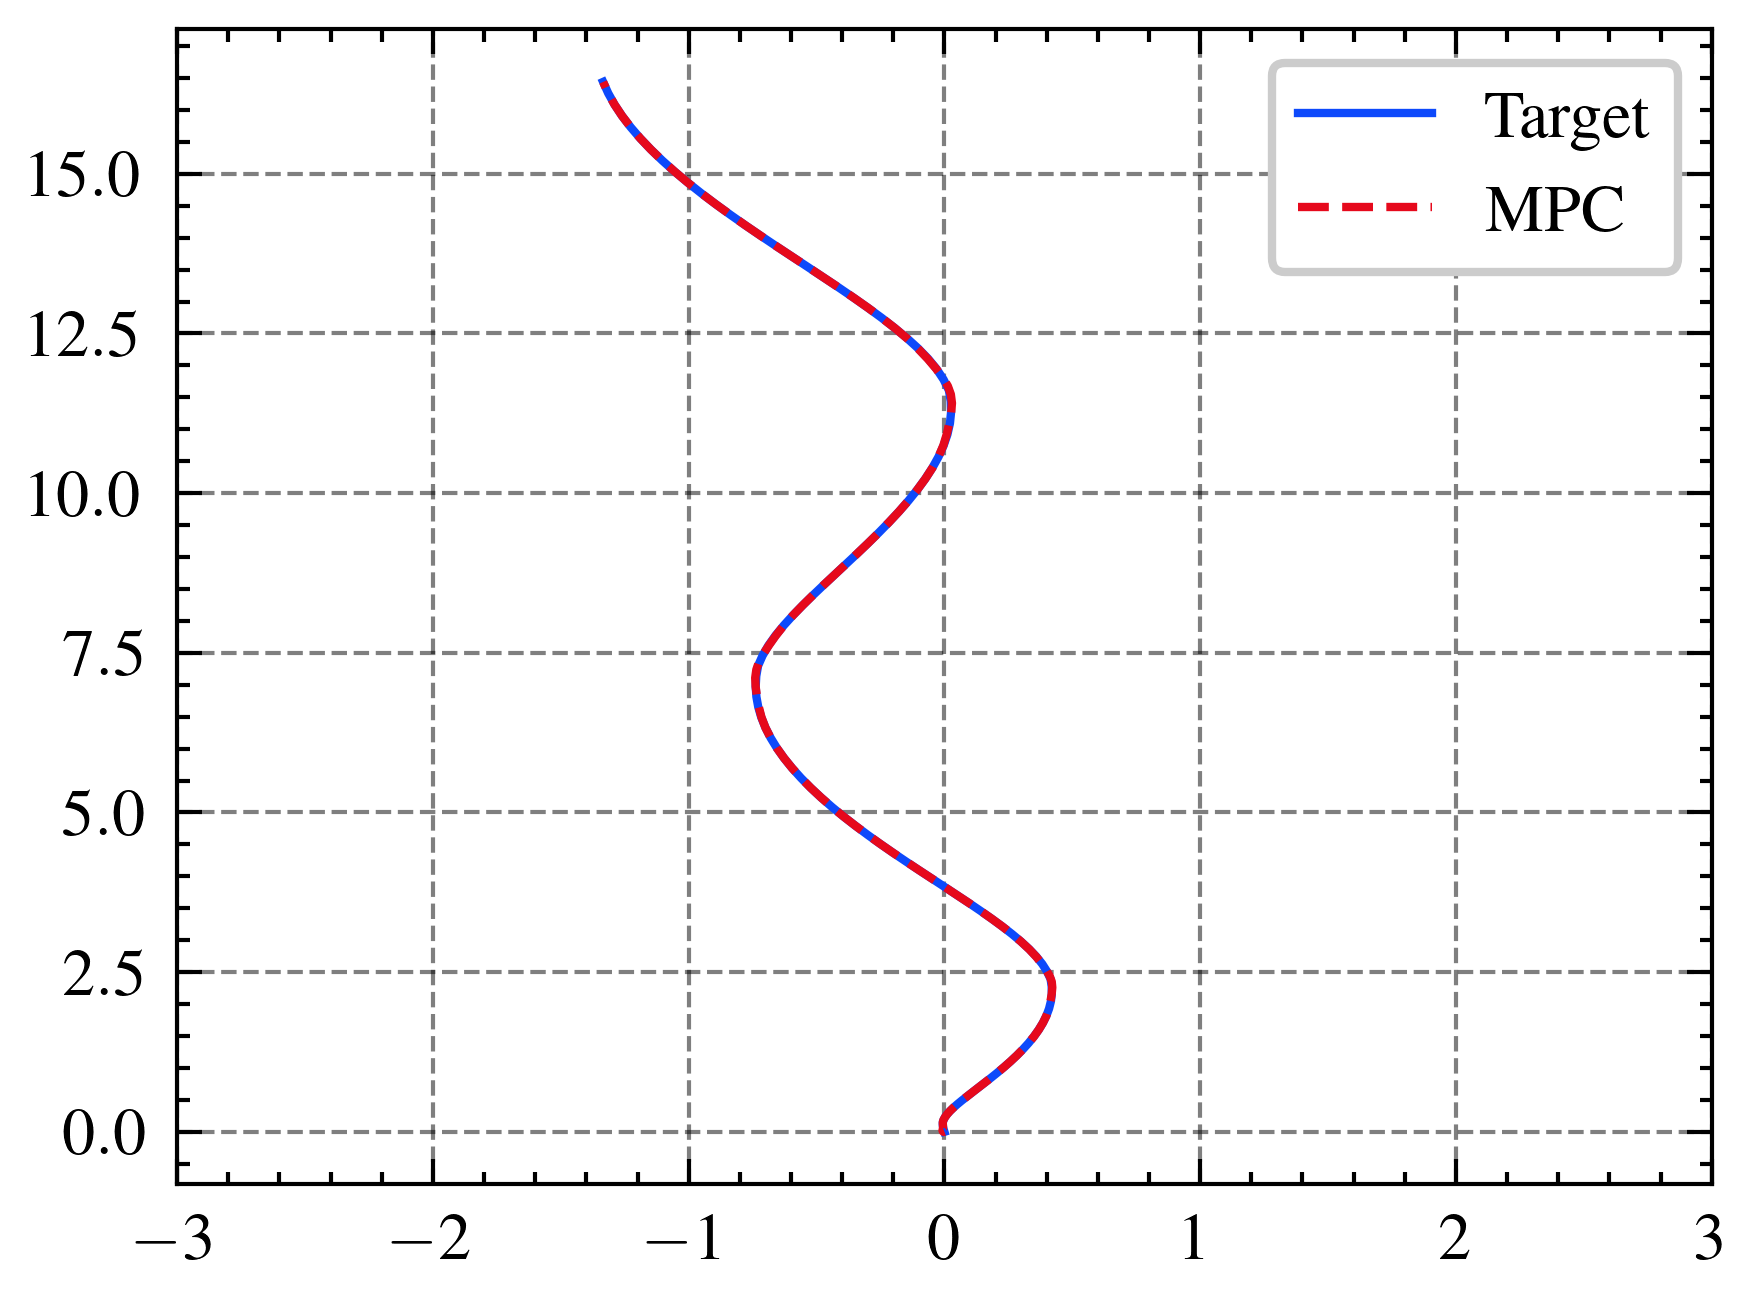

In [38]:
u_ref, v_ref, r_ref, x_bow_ref, y_bow_ref, x_stern_ref, y_stern_ref, psi_ref = obs[['u', 'v', 'r', 'x_bow', 'y_bow', 'x_stern', 'y_stern', 'psi']][0:int(T/dt)].values.T
u, v, r, x_bow, y_bow, x_stern, y_stern, psi = X.T
X_F, Y_F, N_F = U.T
plt.plot(((y_bow_ref+y_stern_ref)/2)/L_pp, ((x_bow_ref+x_stern_ref)/2)/L_pp, label='Target')
plt.plot(((y_bow+y_stern)/2)/L_pp, ((x_bow+x_stern)/2)/L_pp, label='MPC')
plt.legend()
plt.xlim(-3,3)
# plt.plot(obs20['y'], obs20['x'], c='darkorange',linestyle='dashed')


### 空間固定座標系に変換

In [27]:
X_F_fixed = list(
    map(
        lambda X_F, Y_F, psi:
        X_F * np.cos(psi) - Y_F * np.sin(psi)
        ,
        X_F,
        Y_F,
        psi,
    )
)
Y_F_fixed = list(
    map(
        lambda X_F, Y_F, psi:
        X_F * np.sin(psi) + Y_F * np.cos(psi)
        ,
        X_F,
        Y_F,
        psi,
    )
)

(-10.0, 10.0)

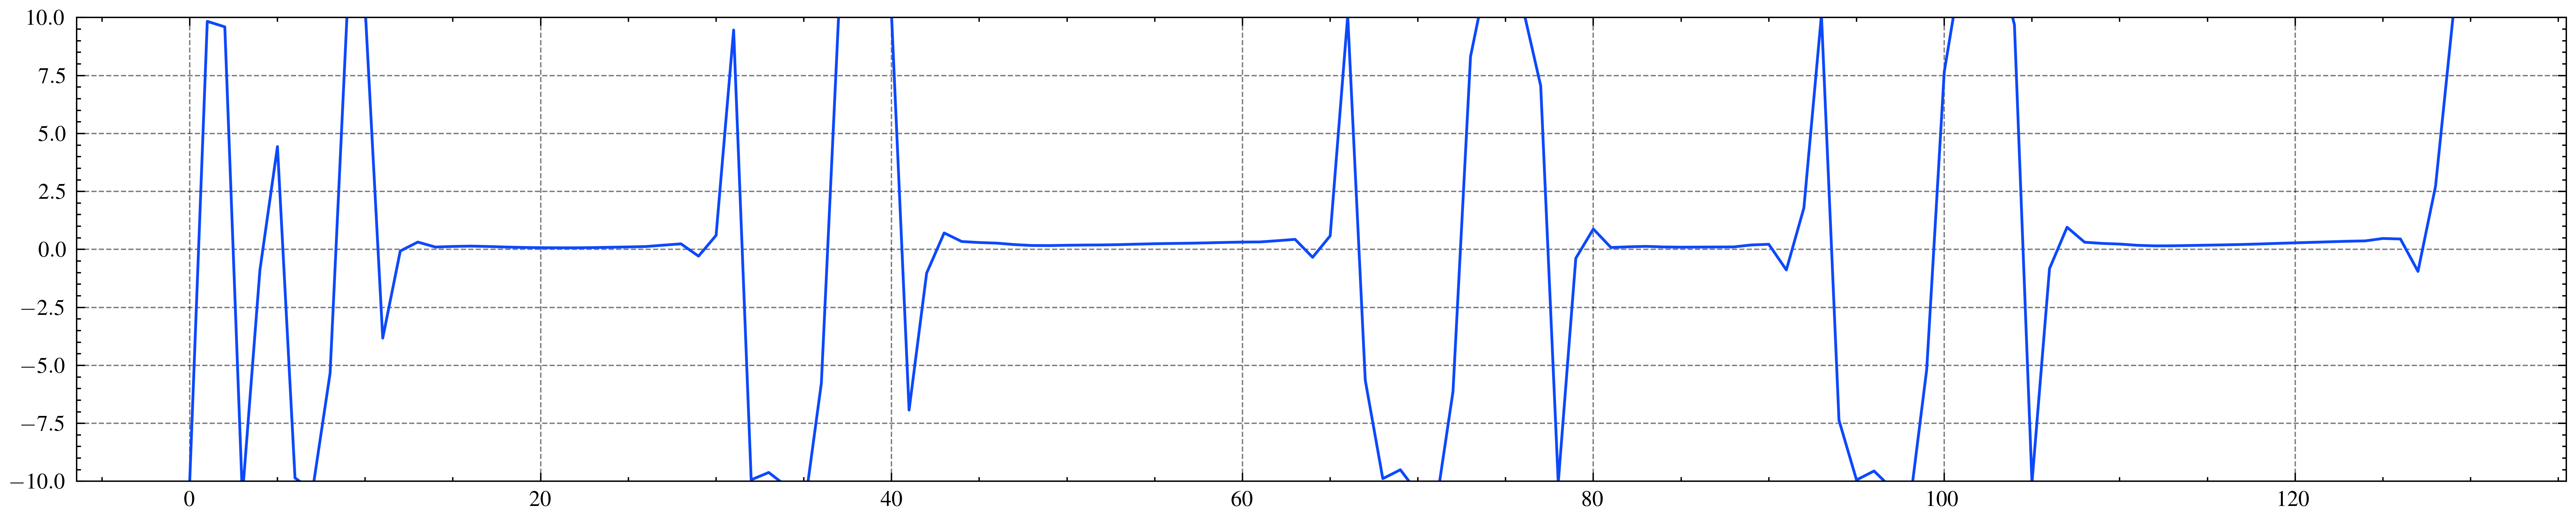

In [28]:
plt.figure(figsize=(16,3))
plt.plot(t_eval, X_F_fixed, label='X_F')
plt.ylim(-10,10)

/var/folders/42/rycq9wgs5g3_yj8bjfwx0mkw0000gn/T/ipykernel_92124/324881926.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/42/rycq9wgs5g3_yj8bjfwx0mkw0000gn/T/ipykernel_92124/324881926.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


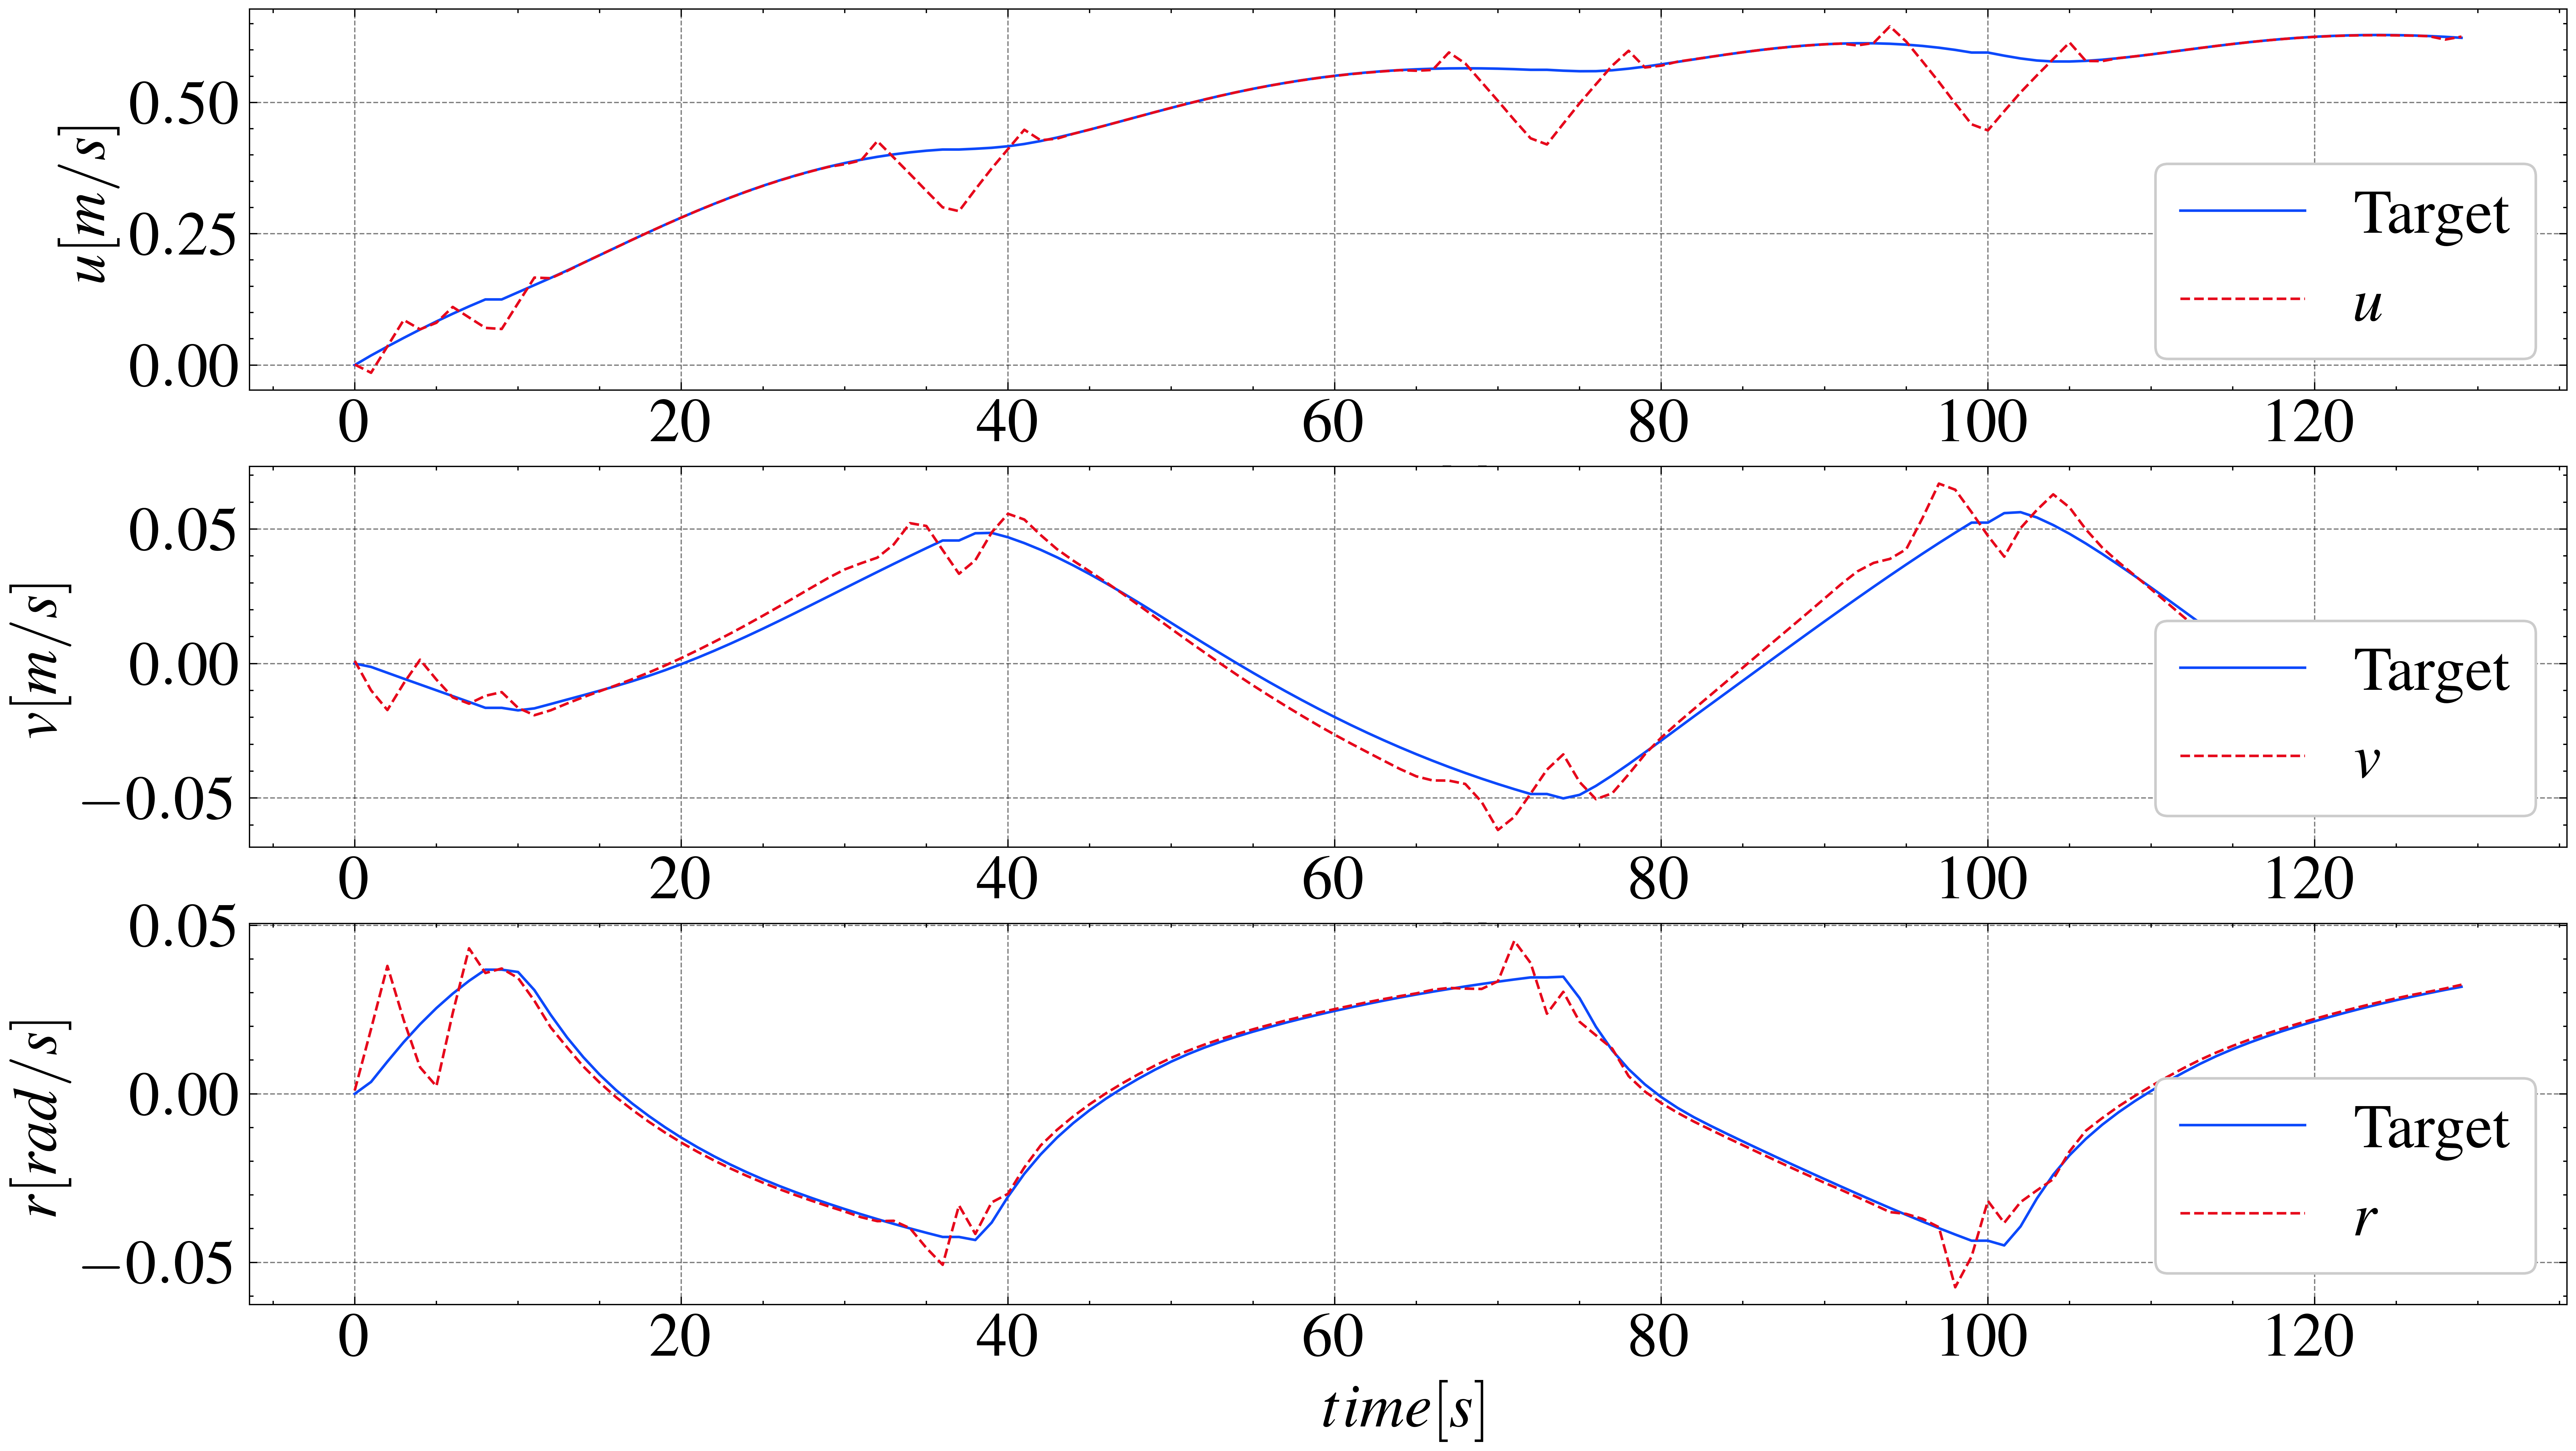

In [40]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(t_eval, u_ref, label='Target')
ax1.plot(t_eval, u, label='$u$')
ax1.set_xlabel('$t_eval[s]$', fontsize=24)
ax1.set_ylabel('$u[m/s]$', fontsize=24)
plt.tick_params(labelsize=24)
# ax1.set_xlim([0, 100])
ax1.legend(frameon=True, loc='lower right', fontsize=24)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(t_eval, v_ref, label='Target')
ax2.plot(t_eval, v, label='$v$')
ax2.set_xlabel('$t_eval[s]$', fontsize=24)
ax2.set_ylabel('$v[m/s]$', fontsize=24)
plt.tick_params(labelsize=24)
# ax2.set_xlim([0, 100])
ax2.legend(frameon=True, loc='lower right', fontsize=24)
fig.show()

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(t_eval, r_ref, label='Target')
ax3.plot(t_eval, r, label='$r$')
ax3.set_xlabel('$time[s]$', fontsize=24)
ax3.set_ylabel('$r[rad/s]$', fontsize=24)
plt.tick_params(labelsize=24)
# ax3.set_xlim([0, 100])
ax3.legend(frameon=True, loc='lower right', fontsize=24)
fig.show()

In [24]:
# # 評価関数の重み　外力が働く場合はQを大きくする
# Q = casadi.diag([1,1,1,1]) # 状態変数の重み
# Q_f = casadi.diag([1,1,1,1])
# R = casadi.diag([1e-5,1e-5,1e-6]) # 制御入力の重み

# # ホライゾン
# K = 50
# T = 130
# dt = 1

# # 制約条件
# x_lb = [-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
# x_ub = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
# u_lb = [-10, -10, -10]
# u_ub = [10, 10, 10]

# nx = 8 # 状態変数の次元
# nu = 3 # 制御入力の次元

# # 目標値
# x_ref = casadi.DM(obs[['x_bow', 'y_bow', 'x_stern', 'y_stern']].values)
# # u_ref = casadi.DM() 設定しない

# # 最適化に現れる全ての変数の次元の合計
# total = nx*(K+1) + nu*K

In [30]:
# def make_f():
#     states = casadi.SX.sym('states', nx)
#     ctrls = casadi.SX.sym('ctrls', nu)
#     # 状態変数
#     u = states[0]
#     v = states[1]
#     r = states[2]
#     x_bow = states[3]
#     y_bow = states[4]
#     x_stern = states[5]
#     y_stern = states[6]
#     psi = states[7]
#     # δ = states[8]
#     # np = states[9]
#     δ = obs['δ'][0]
#     np = obs['npm'][0]
#     # 制御入力
#     X_F = ctrls[0]
#     Y_F = ctrls[1]
#     N_F = ctrls[2]
    
#     u_dot = (X_H(u,v,r)+X_R(u,v,r,δ,np)+X_P(u,v,r,δ,np)+X_F+(m+m_y)*v*r)/(m+m_x)
#     v_dot = (Y_H(u,v,r)+Y_R(u,v,r,δ,np)+Y_F-(m+m_x)*u*r)/(m+m_y)
#     r_dot = (N_H(u,v,r)+N_R(u,v,r,δ,np)+N_F)/(I_zG+J_z)
#     x_bow_dot = u*casadi.cos(psi)-v*casadi.sin(psi)-0.5*L_pp*r*casadi.sin(psi)
#     y_bow_dot = u*casadi.sin(psi)+v*casadi.cos(psi)+0.5*L_pp*r*casadi.cos(psi)
#     x_stern_dot = u*casadi.cos(psi)-v*casadi.sin(psi)+0.5*L_pp*r*casadi.sin(psi)
#     y_stern_dot = u*casadi.sin(psi)+v*casadi.cos(psi)-0.5*L_pp*r*casadi.cos(psi)
#     psi_dot = r
    
#     states_dot = casadi.vertcat(u_dot, v_dot, r_dot, x_bow_dot, y_bow_dot, x_stern_dot, y_stern_dot, psi_dot)
    
#     f = casadi.Function('f',[states,ctrls],[states_dot],
#                         ['x','u'],['x_dot'])
#     return f

# def make_RK4():
#     states = casadi.SX.sym('states',nx) # nxの数を設定
#     ctrls = casadi.SX.sym('ctrls',nu)
    
#     f = make_f()
    
#     r1 = f(x=states,u=ctrls)['x_dot']
#     r2 = f(x=states+dt*r1/2,u=ctrls)['x_dot']
#     r3 = f(x=states+dt*r2/2,u=ctrls)['x_dot']
#     r4 = f(x=states+dt*r3,u=ctrls)['x_dot']
    
#     states_next = states + dt*(r1+2*r2+2*r3+r4)/6
    
#     RK4 = casadi.Function('RK4',[states,ctrls],[states_next],
#                           ['x','u'],['x_next'])
#     return RK4

# def make_integrator():
#     states = casadi.SX.sym('states',nx)
#     ctrls = casadi.SX.sym('ctrls',nu)
    
#     f = make_f()
#     ode = f(x=states,u=ctrls)['x_dot']
    
#     dae = {'x':states,'p':ctrls,'ode':ode}
    
#     I = casadi.integrator('I','cvodes',dae,0,dt)
#     return I

# def compute_stage_cost(x,u,x_ref_slice,k):
#     x_extract = x[3:7]
#     x_diff = x_extract - x_ref_slice[k,:].T
#     u_diff = u
#     # cost = (casadi.dot(Q@x_diff,x_diff)) / 2
#     cost = (casadi.dot(Q@x_diff,x_diff)
#             + casadi.dot(R@u_diff,u_diff)) / 2
#     return cost

# def compute_terminal_cost(x,x_ref_slice):
#     x_extract = x[3:7]
#     x_diff = x_extract - x_ref_slice[-1,:].T
#     cost = casadi.dot(Q_f@x_diff,x_diff) / 2
#     return cost

# def make_nlp(x_ref_slice):
#     RK4 = make_RK4()
#     U = [casadi.SX.sym(f'u_{k}',nu) for k in range(K)]
#     X = [casadi.SX.sym(f'x_{k}',nx) for k in range(K+1)]
#     G = []
    
#     J = 0
    
#     for k in range(K):
#         J += compute_stage_cost(X[k],U[k],x_ref_slice,k)*dt #評価関数はC
#         eq = X[k+1] - RK4(x=X[k],u=U[k])['x_next']
#         G.append(eq) # 制約条件を追加
#     J += compute_terminal_cost(X[-1],x_ref_slice)
    
#     option = {'print_time':False,
#               'ipopt':{'max_iter':500,'print_level':0}}
#     nlp = {'x':casadi.vertcat(*X,*U),'f':J,'g':casadi.vertcat(*G)}
#     # S = casadi.nlpsol('S','ipopt',nlp)
#     S = casadi.nlpsol('S','ipopt',nlp,option)
#     return S

# def compute_optimal_control(S,x_init,x0):
#     x_init = x_init.full().ravel().tolist()
    
#     lbx = x_init + x_lb*K + u_lb*K
#     ubx = x_init + x_ub*K + u_ub*K
#     lbg = [0]*nx*K
#     ubg = [0]*nx*K
    
#     res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
#     offset = nx*(K+1)
#     x0 = res['x']
#     u_opt = x0[offset:offset+nu]
#     return u_opt, x0

# t_span = [0,130]
# t_eval = np.arange(*t_span,dt)

# if obs['u'][0]==obs['v'][0]==obs['r'][0]==0:
#     x_init = casadi.DM([1,1,1,obs['x_bow'][0], obs['y_bow'][0], obs['x_stern'][0], obs['y_stern'][0],obs['psi'][0]])
# else:
#     x_init = casadi.DM([obs['u'][0],obs['v'][0],obs['r'][0],obs['x_bow'][0], obs['y_bow'][0], obs['x_stern'][0], obs['y_stern'][0],obs['psi'][0]])
# x0 = casadi.vertcat(x_init,casadi.DM.ones(nx*K)*1,casadi.DM([0,0,0]),casadi.DM.ones(nu*(K-1))*1)


# # S = make_nlp(x_ref_slice)
# I = make_integrator()

# X = [x_init]
# U = []
# x_current = x_init
# for t in t_eval:
#     # tに応じて目標のスライスを決定
#     start = int(t/dt)
#     end = start + K
#     x_ref_slice = x_ref[start:end,:]
    
#     S = make_nlp(x_ref_slice)
#     u_opt,x0 = compute_optimal_control(S,x_current,x0)
#     x_current = I(x0=x_current,p=u_opt)['xf']
#     X.append(x_current)
#     U.append(u_opt)
    
# X.pop()
# X = np.array(X).reshape(t_eval.size,nx)
# U = np.array(U).reshape(t_eval.size,nu)

In [32]:
# u_ref, v_ref, r_ref, x_bow_ref, y_bow_ref, x_stern_ref, y_stern_ref, psi_ref = obs[['u', 'v', 'r', 'x_bow', 'y_bow', 'x_stern', 'y_stern', 'psi']].values.T
# u, v, r, x_bow, y_bow, x_stern, y_stern, psi = X.T
# X_F, Y_F, N_F = U.T
# plt.plot((y_bow+y_stern)/2, (x_bow+x_stern)/2, c='b')
# plt.plot((y_bow_ref+y_stern_ref)/2, (x_bow_ref+x_stern_ref)/2)

In [9]:
# X_F_fixed = list(
#     map(
#         lambda X_F, Y_F, psi:
#         X_F * np.cos(psi) - Y_F * np.sin(psi)
#         ,
#         X_F,
#         Y_F,
#         psi,
#     )
# )
# Y_F_fixed = list(
#     map(
#         lambda X_F, Y_F, psi:
#         X_F * np.sin(psi) + Y_F * np.cos(psi)
#         ,
#         X_F,
#         Y_F,
#         psi,
#     )
# )

In [31]:
# plt.figure(figsize=(16,3))
# plt.plot(t_eval, X_F_fixed, label='X_F')
# plt.ylim(-10,10)